In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import joblib 
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer

In [3]:
# Load all your models
ols_model = joblib.load('models/ols_model.pkl')
ridge_model = joblib.load('models/ridge_model.pkl')
lasso_model = joblib.load('models/lasso_model.pkl')
rf_model = joblib.load('models/rf_model.pkl')

In [4]:
df = pd.read_csv('data/merged_climate_iom_data.csv')

In [5]:
# Sorting by country and time to ensure proper filling
df.sort_values(by=["country_code", "year", "month"], inplace=True)

columns_to_fill_extended = [
    "AG.LND.FRST.K2", "AG.LND.PRCP.MM", "AG.LND.TOTL.K2", "AG.SRF.TOTL.K2",
    "EG.CFT.ACCS.RU.ZS", "EG.CFT.ACCS.UR.ZS", "EG.CFT.ACCS.ZS", "EG.EGY.PRIM.PP.KD", "EG.ELC.ACCS.ZS", "EG.FEC.RNEW.ZS",
    "EN.GHG.ALL.MT.CE.AR5", "EN.GHG.CH4.AG.MT.CE.AR5", "EN.GHG.CH4.BU.MT.CE.AR5", "EN.GHG.CH4.FE.MT.CE.AR5",
    "EN.GHG.CH4.IC.MT.CE.AR5", "EN.GHG.CH4.MT.CE.AR5", "EN.GHG.CH4.PI.MT.CE.AR5", "EN.GHG.CH4.TR.MT.CE.AR5",
    "EN.GHG.CH4.WA.MT.CE.AR5", "EN.GHG.CO2.BU.MT.CE.AR5", "EN.GHG.CO2.IC.MT.CE.AR5", "EN.GHG.CO2.IP.MT.CE.AR5",
    "EN.GHG.CO2.LU.MT.CE.AR5", "EN.GHG.CO2.MT.CE.AR5", "EN.GHG.CO2.PI.MT.CE.AR5", "EN.GHG.CO2.TR.MT.CE.AR5",
    "EN.GHG.FGAS.IP.MT.CE.AR5", "EN.GHG.N2O.AG.MT.CE.AR5", "EN.GHG.N2O.BU.MT.CE.AR5", "EN.GHG.N2O.FE.MT.CE.AR5",
    "EN.GHG.N2O.IC.MT.CE.AR5", "EN.GHG.N2O.IP.MT.CE.AR5", "EN.GHG.N2O.MT.CE.AR5", "EN.GHG.N2O.PI.MT.CE.AR5",
    "EN.GHG.N2O.TR.MT.CE.AR5", "EN.GHG.N2O.WA.MT.CE.AR5", "ER.FSH.AQUA.MT", "ER.FSH.CAPT.MT", "ER.FSH.PROD.MT",
    "ER.H2O.FWTL.K3", "ER.H2O.INTR.K3", "SP.POP.TOTL"
]

columns_to_fill_extended = [col.lower() for col in columns_to_fill_extended]

# Filtering columns that exist in the dataset
existing_columns = [col for col in columns_to_fill_extended if col in df.columns]

df[existing_columns] = df.groupby("country_code")[existing_columns].transform(lambda x: x.ffill().bfill())

In [6]:
df['total_idp_over_pop'] = (df['internally_displaced_persons'] / df['sp.pop.totl'])*100
df['total_affected_over_pop'] = (df['total_affected'] / df['sp.pop.totl'])*100

In [7]:
weird_values = df[df['total_idp_over_pop'] > 100]

In [8]:
len(weird_values)

8

In [9]:
weird_values[['year','country_name', 'sp.pop.totl','internally_displaced_persons',  'total_idp_over_pop', 'total_affected_over_pop']].describe()

,year,sp.pop.totl,internally_displaced_persons,total_idp_over_pop,total_affected_over_pop
count,8.000000,8.000000e+00,8.000000e+00,8.000000,3.000000
mean,2022.250000,3.535141e+07,4.878471e+07,129.245549,49.949904
std,1.035098,2.027603e+07,3.285272e+07,29.424648,36.602761
min,2021.000000,1.086578e+07,1.114828e+07,102.599951,7.684676
25%,2021.000000,1.086578e+07,1.205802e+07,110.972392,39.383597
50%,2023.000000,5.004279e+07,5.963956e+07,119.177121,71.082518
75%,2023.000000,5.004279e+07,6.685620e+07,133.598064,71.082518
max,2023.000000,5.004279e+07,9.545158e+07,190.739913,71.082518


In [10]:
# Removing odd values, where we have more than 100% of the population displaced
df = df[df['total_idp_over_pop'] < 100]

In [11]:
# do a log transformation of the target variable
df['internally_displaced_persons'] = np.log1p(df['internally_displaced_persons'])

In [12]:
df.internally_displaced_persons

340    13.513171
380    14.857745
459    15.461179
490    15.525970
521    15.538416
         ...    
655    11.237185
769    11.566457
795    10.977619
822    11.716087
838    11.732912
Name: internally_displaced_persons, Length: 909, dtype: float64

In [13]:
env_factors = [
'ag.lnd.frst.k2', 'ag.lnd.prcp.mm',
       'ag.lnd.totl.k2', 'ag.srf.totl.k2', 'eg.cft.accs.ru.zs',
       'eg.cft.accs.ur.zs', 'eg.cft.accs.zs', 'eg.egy.prim.pp.kd',
       'eg.elc.accs.zs', 'eg.fec.rnew.zs', 'en.ghg.all.mt.ce.ar5',
       'en.ghg.ch4.ag.mt.ce.ar5', 'en.ghg.ch4.bu.mt.ce.ar5',
       'en.ghg.ch4.fe.mt.ce.ar5', 'en.ghg.ch4.ic.mt.ce.ar5',
       'en.ghg.ch4.mt.ce.ar5', 'en.ghg.ch4.pi.mt.ce.ar5',
       'en.ghg.ch4.tr.mt.ce.ar5', 'en.ghg.ch4.wa.mt.ce.ar5',
       'en.ghg.co2.bu.mt.ce.ar5', 'en.ghg.co2.ic.mt.ce.ar5',
       'en.ghg.co2.ip.mt.ce.ar5', 'en.ghg.co2.lu.mt.ce.ar5',
       'en.ghg.co2.mt.ce.ar5', 'en.ghg.co2.pi.mt.ce.ar5',
       'en.ghg.co2.tr.mt.ce.ar5', 'en.ghg.fgas.ip.mt.ce.ar5',
       'en.ghg.n2o.ag.mt.ce.ar5', 'en.ghg.n2o.bu.mt.ce.ar5',
       'en.ghg.n2o.fe.mt.ce.ar5', 'en.ghg.n2o.ic.mt.ce.ar5',
       'en.ghg.n2o.ip.mt.ce.ar5', 'en.ghg.n2o.mt.ce.ar5',
       'en.ghg.n2o.pi.mt.ce.ar5', 'en.ghg.n2o.tr.mt.ce.ar5',
       'en.ghg.n2o.wa.mt.ce.ar5', 'er.fsh.aqua.mt', 'er.fsh.capt.mt',
       'er.fsh.prod.mt', 'er.h2o.fwtl.k3', 'er.h2o.intr.k3', 'sp.pop.totl',
       'cpi_value', 'total_affected']

#impute mean to nas in env_factors

for col in env_factors:
       if col == 'total_affected':
              df[col].fillna(0, inplace=True)
       else:
              df[col].fillna(df[col].mean(), inplace=True)
df_clean = df
# Define independent (X) and dependent (y) variables
X = df_clean[env_factors]  # Environmental factors
y = df_clean["internally_displaced_persons"]  # Displacement

# Add a constant term for the regression model
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

/var/folders/p2/6x334wb90dvdf75sfntm2bxw0000gn/T/ipykernel_1787/2181285737.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)
/var/folders/p2/6x334wb90dvdf75sfntm2bxw0000gn/T/ipykernel_1787/2181285737.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always b

#### OLS Regression

In [14]:
# Split data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the regression model on the training set
model_train = sm.OLS(y_train, X_train).fit()

# Predict on the test set
y_pred = model_train.predict(X_test)

# Evaluate model performance
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae, r2

(1.2467414608805198, 0.07176022570106966)

#### Cross Validation for the OLS Model:
- First intent with K fold
- Note for fixing:  Do cross validation in the proportion of affected / total

In [15]:
# 1. Set up K-Fold cross-validation
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# 2. Initialize lists to store metrics
mae_scores = []
r2_scores = []

# 3. Perform manual cross-validation with statsmodels
for train_index, test_index in kf.split(X):
    # Split data for this fold
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    
    # Train statsmodels OLS
    model_fold = sm.OLS(y_train_fold, X_train_fold).fit()
    
    # Make predictions
    y_pred_fold = model_fold.predict(X_test_fold)
    
    # Calculate and store performance metrics
    mae = mean_absolute_error(y_test_fold, y_pred_fold)
    r2 = r2_score(y_test_fold, y_pred_fold)
    
    mae_scores.append(mae)
    r2_scores.append(r2)

# 4. Calculate average performance
avg_mae = np.mean(mae_scores)
avg_r2 = np.mean(r2_scores)
std_mae = np.std(mae_scores)
std_r2 = np.std(r2_scores)

print(f"Cross-validation MAE: {avg_mae:.4f} ± {std_mae:.4f}")
print(f"Cross-validation R²: {avg_r2:.4f} ± {std_r2:.4f}")

Cross-validation MAE: 1.3949 ± 0.1687
Cross-validation R²: 0.0898 ± 0.0706


#### Random Forest Model

In [16]:
# Convert categorical variables to numerical using one-hot encoding
df_encoded = pd.get_dummies(df_clean.drop(columns=["internally_displaced_persons"]), drop_first=True)

# Fill missing values with the median
#df_encoded = df_encoded.fillna(df_encoded.median(numeric_only=True))
#y_filled = df["internally_displaced_persons"]

# Split into train and test sets
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(df_encoded[env_factors], y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)

# Predict on test set
y_pred_rf = rf_model.predict(X_test_rf)

# Evaluate model performance
mae_rf = mean_absolute_error(y_test_rf, y_pred_rf)
r2_rf = r2_score(y_test_rf, y_pred_rf)

mae_rf, r2_rf

(0.6268454693874563, 0.6480114715788236)

#### Cross Validation for the Random Forest Model

In [17]:
# Setup K-fold cross-validation
k = 5  # adjust?? i think this is already pretty solid
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Prepare data
X = df_encoded[env_factors]
y = y

# Initialize lists to store performance metrics
mae_scores = []
r2_scores = []

# Perform cross-validation
for train_index, test_index in kf.split(X):
    # Split data for this fold
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    
    # Train model
    rf_model.fit(X_train_fold, y_train_fold)
    
    # Make predictions
    y_pred_fold = rf_model.predict(X_test_fold)
    
    # Calculate and store performance metrics
    mae = mean_absolute_error(y_test_fold, y_pred_fold)
    r2 = r2_score(y_test_fold, y_pred_fold)
    
    mae_scores.append(mae)
    r2_scores.append(r2)

# Calculate average performance
avg_mae = np.mean(mae_scores)
avg_r2 = np.mean(r2_scores)
std_mae = np.std(mae_scores)
std_r2 = np.std(r2_scores)

print(f"Cross-validation MAE: {avg_mae:.4f} ± {std_mae:.4f}")
print(f"Cross-validation R²: {avg_r2:.4f} ± {std_r2:.4f}")

Cross-validation MAE: 0.7676 ± 0.0858
Cross-validation R²: 0.6063 ± 0.0457


In [29]:
import pandas as pd
import matplotlib.pyplot as plt

feature_importances = rf_model.feature_importances_
# Assuming env_factors contains the feature names
feature_names = df_encoded[env_factors].columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort by importance in descending order
importance_df = importance_df.sort_values('Importance', ascending=False)
# Print the top 10 most important features
print("Top 10 Most Important Features:")
print(importance_df.head(10))


Top 10 Most Important Features:
                     Feature  Importance
41               sp.pop.totl    0.681641
43            total_affected    0.025537
9             eg.fec.rnew.zs    0.018654
42                 cpi_value    0.012977
25   en.ghg.co2.tr.mt.ce.ar5    0.012083
18   en.ghg.ch4.wa.mt.ce.ar5    0.011293
31   en.ghg.n2o.ip.mt.ce.ar5    0.011275
12   en.ghg.ch4.bu.mt.ce.ar5    0.010748
26  en.ghg.fgas.ip.mt.ce.ar5    0.009427
19   en.ghg.co2.bu.mt.ce.ar5    0.009281


### Cross Validation for Ridge and Lasso 
Approach 1

In [18]:
models = {
    'Ridge': joblib.load('models/ridge_model.pkl'),
    'Lasso': joblib.load('models/lasso_model.pkl')
}   

# rename a variable but this has already been transformed before ->f['internally_displaced_persons'] = np.log1p(df['internally_displaced_persons'])
y_log = df_clean['internally_displaced_persons']

# Create a simple test set (there are very high values so it has been problematic)
X_train, X_test, y_train, y_test = train_test_split(
      X, y_log, test_size=0.2, random_state=42 
)
# Transform back to get original scale values for evaluation
y_test_original = np.expm1(y_test)

# fit models
ridge_model = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=0.001)) # maybe we can try different alphas ??
])

lasso_model = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso(alpha=0.001)) # maybe we can try different alphas  also??
])

# Fit the models
ridge_model.fit(X_train, y_train)
lasso_model.fit(X_train, y_train)

/Applications/anaconda3/envs/ml2025/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.606e+02, tolerance: 3.035e-01
  model = cd_fast.enet_coordinate_descent(


Pipeline(steps=[('scaler', StandardScaler()), ('lasso', Lasso(alpha=0.001))])

In [19]:
# Function to evaluate models with careful prediction handling
def evaluate_models_safely(models_dict, X_test, y_test_log, y_test_original):
    results = []
    
    for name, model in models_dict.items():
        print(f"\nEvaluating {name} model...")
        try:
            # Get predictions in log space with error catching
            try:
                y_pred_log = model.predict(X_test)
                print(f"  Log predictions range: {np.min(y_pred_log):.4f} to {np.max(y_pred_log):.4f}")
            except Exception as e:
                print(f"  Error during prediction: {str(e)}")
                continue
                
            # Calculate metrics in log space
            mae_log = mean_absolute_error(y_test_log, y_pred_log)
            r2_log = r2_score(y_test_log, y_pred_log)
            print(f"  MAE (log): {mae_log:.4f}")
            print(f"  R² (log): {r2_log:.4f}")
            
            # Safe conversion to original scale
            # If predictions are too large, clip them before transformation
            if np.max(y_pred_log) > 20:
                print(f"  Warning: Clipping large predictions > 20 ({np.sum(y_pred_log > 20)} values)")
                y_pred_log_safe = np.clip(y_pred_log, None, 20)
            else:
                y_pred_log_safe = y_pred_log
                
            # Transform back to original scale
            y_pred_original = np.expm1(y_pred_log_safe)
            
            # Calculate metrics in original scale
            mae_original = mean_absolute_error(y_test_original, y_pred_original)
            r2_original = r2_score(y_test_original, y_pred_original)
            print(f"  MAE (original): {mae_original:.1f}")
            print(f"  R² (original): {r2_original:.4f}")
            
            # Add to results
            results.append({
                'Model': name,
                'MAE (log)': mae_log,
                'R² (log)': r2_log,
                'MAE (original)': mae_original,
                'R² (original)': r2_original
            })
            
        except Exception as e:
            print(f"  Error in evaluation: {str(e)}")
            results.append({
                'Model': name,
                'MAE (log)': float('nan'),
                'R² (log)': float('nan'),
                'MAE (original)': float('nan'),
                'R² (original)': float('nan')
            })
    
    return pd.DataFrame(results)

# Evaluate the models
models_to_evaluate = {
    'Ridge': ridge_model,
    'Lasso': lasso_model
}

results_df = evaluate_models_safely(models_to_evaluate, X_test, y_test, y_test_original)
print("\nEvaluation Results:")
print(results_df.round(4))


Evaluating Ridge model...
  Log predictions range: 11.0989 to 17.0806
  MAE (log): 1.2494
  R² (log): 0.0637
  MAE (original): 2409124.9
  R² (original): -0.4772

Evaluating Lasso model...
  Log predictions range: 11.1859 to 17.1280
  MAE (log): 1.2455
  R² (log): 0.0717
  MAE (original): 2415055.5
  R² (original): -0.5015

Evaluation Results:
   Model  MAE (log)  R² (log)  MAE (original)  R² (original)
0  Ridge     1.2494    0.0637    2.409125e+06        -0.4772
1  Lasso     1.2455    0.0717    2.415056e+06        -0.5015


#### Interpretation of results:
**Ridge Regression (alpha = 1.0)**
- Log scale performance (R² = 0.07): The moderate regularization strength (alpha = 1.0) is excessively shrinking coefficients for log-transformed data, resulting in poor explanatory power; the regularization is causing underfitting rather than generalization. SO SHOULD WE CHANGE THE ALPHA?

- Original scale performance (R² = -0.52/-4.98): The exponential back-transformation of already poor log-scale predictions amplifies errors, regularization penalty prevents the model from capturing the true scale of values; negative R² indicates the model performs substantially worse than simply predicting the mean value.

**Lasso Regression (alpha = 0.1)**
- Log scale performance (R² = 0.06): The feature selection penalty (alpha = 0.1) is likely eliminating important predictors needed for accurately modeling log-transformed displacement, resulting iN oversimplified model that captures barely 6% of the variance in the data.

- Original scale performance (R² = -0.26/-5.00): Coefficient structure created by Lasso's aggresive feature selection fails when predictions are transformed back to the original scale

Finding optimal alpha for Ridge regression...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Ridge alpha: 100.0

Finding optimal alpha for Lasso regression...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Applications/anaconda3/envs/ml2025/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.053e+02, tolerance: 2.300e-01
  model = cd_fast.enet_coordinate_descent(
/Applications/anaconda3/envs/ml2025/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.538e+02, tolerance: 2.300e-01
  model = cd_fast.enet_coordinate_descent(
/Applications/anaconda3/envs/ml2025/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or co

Best Lasso alpha: 0.046415888336127774


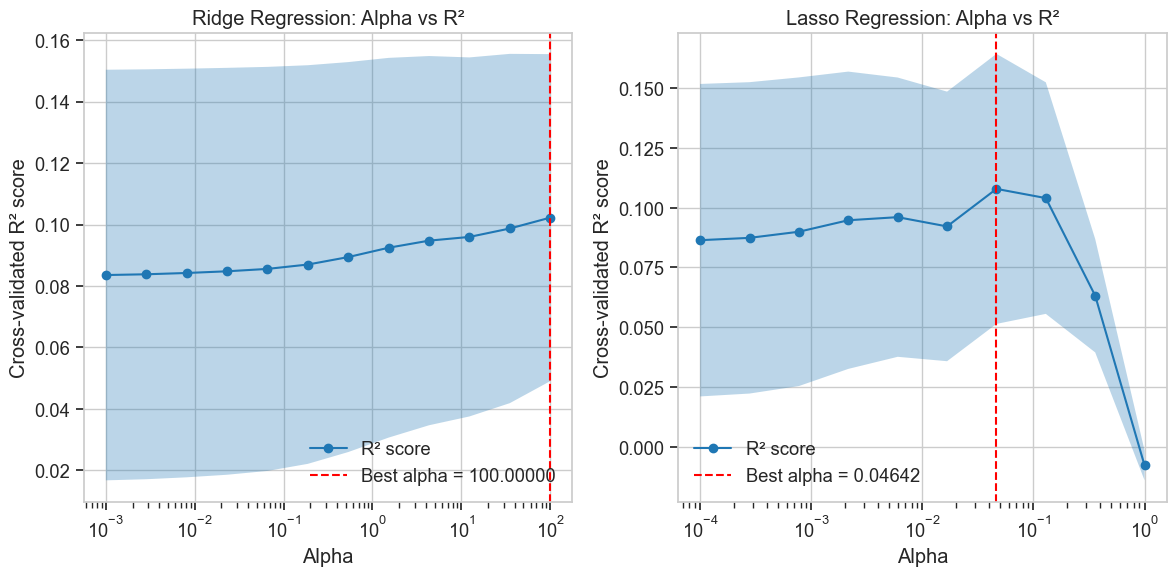

In [20]:
# search best alpha value
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

# Set a nice plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

lasso_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso())
])

# Define alpha values to test
# Use a wide range of values on a log scale to thoroughly explore the parameter space
ridge_alphas = np.logspace(-3, 2, 12)  # 12 values from 0.001 to 100
lasso_alphas = np.logspace(-4, 0, 10)  # 10 values from 0.0001 to 1

# Step 1d: Perform grid search to find best alpha values
ridge_param_grid = {'ridge__alpha': ridge_alphas}
lasso_param_grid = {'lasso__alpha': lasso_alphas}

# Grid search for Ridge
print("Finding optimal alpha for Ridge regression...")
ridge_grid = GridSearchCV(
    ridge_pipeline, 
    ridge_param_grid, 
    cv=5,
    scoring='r2',
    n_jobs=-1,  # Use all available cores
    verbose=1
)
ridge_grid.fit(X_train, y_train)
best_ridge_alpha = ridge_grid.best_params_['ridge__alpha']
print(f"Best Ridge alpha: {best_ridge_alpha}")

# Grid search for Lasso
print("\nFinding optimal alpha for Lasso regression...")
lasso_grid = GridSearchCV(
    lasso_pipeline, 
    lasso_param_grid, 
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)
lasso_grid.fit(X_train, y_train)
best_lasso_alpha = lasso_grid.best_params_['lasso__alpha']
print(f"Best Lasso alpha: {best_lasso_alpha}")

# Step 1e: Visualize regularization path
plt.figure(figsize=(12, 6))

# Plot Ridge regularization path
plt.subplot(1, 2, 1)
mean_scores = ridge_grid.cv_results_['mean_test_score']
std_scores = ridge_grid.cv_results_['std_test_score']
plt.semilogx(ridge_alphas, mean_scores, 'o-', label='R² score')
plt.fill_between(ridge_alphas, 
                 mean_scores - std_scores,
                 mean_scores + std_scores, 
                 alpha=0.3)
plt.axvline(best_ridge_alpha, color='red', linestyle='--', 
           label=f'Best alpha = {best_ridge_alpha:.5f}')
plt.xlabel('Alpha')
plt.ylabel('Cross-validated R² score')
plt.title('Ridge Regression: Alpha vs R²')
plt.legend()
plt.grid(True)

# Plot Lasso regularization path
plt.subplot(1, 2, 2)
mean_scores = lasso_grid.cv_results_['mean_test_score']
std_scores = lasso_grid.cv_results_['std_test_score']
plt.semilogx(lasso_alphas, mean_scores, 'o-', label='R² score')
plt.fill_between(lasso_alphas, 
                 mean_scores - std_scores,
                 mean_scores + std_scores, 
                 alpha=0.3)
plt.axvline(best_lasso_alpha, color='red', linestyle='--',
           label=f'Best alpha = {best_lasso_alpha:.5f}')
plt.xlabel('Alpha')
plt.ylabel('Cross-validated R² score')
plt.title('Lasso Regression: Alpha vs R²')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('alpha_optimization.png', dpi=300)
plt.show()

# Save the best models
best_ridge_model = ridge_grid.best_estimator_
best_lasso_model = lasso_grid.best_estimator_

In [ ]:
# evaluation function for both log and original scales
def evaluate_model_with_optimal_alpha(model, model_name, X_test, y_log_test):
    """Evaluate model performance in both log and original scales."""
    print(f"\nEvaluating {model_name} with optimal alpha...")
    
    # Get alpha value from model
    if model_name == 'Ridge':
        alpha = model.named_steps['ridge'].alpha
    else:  # Lasso
        alpha = model.named_steps['lasso'].alpha
    print(f"Alpha value: {alpha:.6f}")
    
    # Get predictions in log space
    y_log_pred = model.predict(X_test)
    
    # Calculate metrics in log space
    mae_log = mean_absolute_error(y_log_test, y_log_pred)
    r2_log = r2_score(y_log_test, y_log_pred)
    print(f"Log space: MAE = {mae_log:.4f}, R² = {r2_log:.4f}")
    
    # Transform to original scale for evaluation
    y_original_test = np.expm1(y_log_test)
    y_original_pred = np.expm1(y_log_pred)
    
    # Calculate metrics in original scale
    mae_original = mean_absolute_error(y_original_test, y_original_pred)
    r2_original = r2_score(y_original_test, y_original_pred)
    print(f"Original scale: MAE = {mae_original:.1f}, R² = {r2_original:.4f}")
    
    # Return results as a dictionary
    return {
        'Model': model_name,
        'Alpha': alpha,
        'MAE (log)': mae_log,
        'R² (log)': r2_log,
        'MAE (original)': mae_original,
        'R² (original)': r2_original
    }

# evaluate both models with optimal alpha
results = []

# Ridge
ridge_results = evaluate_model_with_optimal_alpha(
    best_ridge_model, 'Ridge', X_test, y_test
)
results.append(ridge_results)

# Lasso
lasso_results = evaluate_model_with_optimal_alpha(
    best_lasso_model, 'Lasso', X_test, y_test
)
results.append(lasso_results)

# Create DataFrame with results
optimal_results_df = pd.DataFrame(results)

# Display the results
print("\nResults with Optimal Alpha Values:")
print(optimal_results_df.to_string(index=False))


Evaluating Ridge with optimal alpha...
Alpha value: 100.000000
Log space: MAE = 1.2530, R² = 0.0793
Original scale: MAE = 2447615.0, R² = -0.4351

Evaluating Lasso with optimal alpha...
Alpha value: 0.046416
Log space: MAE = 1.2570, R² = 0.0697
Original scale: MAE = 2397977.0, R² = -0.3043

Results with Optimal Alpha Values:
Model      Alpha  MAE (log)  R² (log)  MAE (original)  R² (original)
Ridge 100.000000   1.253029  0.079349    2.447615e+06      -0.435076
Lasso   0.046416   1.256997  0.069695    2.397977e+06      -0.304314


In [22]:
# dataframe with the results
optimal_results_df

,Model,Alpha,MAE (log),R² (log),MAE (original),R² (original)
0,Ridge,100.000000,1.253029,0.079349,2.447615e+06,-0.435076
1,Lasso,0.046416,1.256997,0.069695,2.397977e+06,-0.304314


In [23]:
# models
ols_model = joblib.load('models/ols_model.pkl')
rf_model = joblib.load('models/rf_model.pkl')


In [24]:
# transform results to original scale OLS and RF
from sklearn.metrics import mean_absolute_error, r2_score

# invert the log1 transf for original scale
y_test_ols_original = np.expm1(y_test) #ols
y_test_rf_original = np.expm1(y_test_rf) #rf

# invert the log1p transformation for predictions
y_pred_ols_original = np.expm1(y_pred) #ols
y_pred_rf_original = np.expm1(y_pred_rf) #rf

# calculate metrics for OLS
ols_mae = mean_absolute_error(y_test_ols_original, y_pred_ols_original)
ols_r2 = r2_score(y_test_ols_original, y_pred_ols_original)

# calculate metrics for RF
rf_mae = mean_absolute_error(y_test_rf_original, y_pred_rf_original)
rf_r2 = r2_score(y_test_rf_original, y_pred_rf_original)

# print the results in original scale
print(f"OLS Model - MAE (original): {ols_mae:.1f}, R² (original): {ols_r2:.4f}")
print(f"RF Model - MAE (original): {rf_mae:.1f}, R² (original): {rf_r2:.4f}")

OLS Model - MAE (original): 2403479.6, R² (original): -0.4746
RF Model - MAE (original): 996743.8, R² (original): 0.6338


In [25]:
# df with log and original scale results for just OLS and RF
ols_rf_results = pd.DataFrame({
    'Model': ['OLS', 'RF'],
    'MAE (log)': [mae, mae_rf],
    'R² (log)': [r2, r2_rf],
    'MAE (original)': [ols_mae, rf_mae],
    'R² (original)': [ols_r2, rf_r2]
})
ols_rf_results

,Model,MAE (log),R² (log),MAE (original),R² (original)
0,OLS,0.738196,0.602456,2.403480e+06,-0.474601
1,RF,0.626845,0.648011,9.967438e+05,0.633773


In [ ]:
import numpy as np 

# feature importance for RF
feature_importance = pd.DataFrame({
    'Feature': rf_model.feature_names_in_,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 most important features:")
print(feature_importance.head(10).to_string(index=False))


Top 10 most important features:
                 Feature  Importance
             sp.pop.totl    0.681641
          total_affected    0.025537
          eg.fec.rnew.zs    0.018654
               cpi_value    0.012977
 en.ghg.co2.tr.mt.ce.ar5    0.012083
 en.ghg.ch4.wa.mt.ce.ar5    0.011293
 en.ghg.n2o.ip.mt.ce.ar5    0.011275
 en.ghg.ch4.bu.mt.ce.ar5    0.010748
en.ghg.fgas.ip.mt.ce.ar5    0.009427
 en.ghg.co2.bu.mt.ce.ar5    0.009281
